In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from pyspectools.models.classes import SpecConstants, MoleculeDetective

/home/kelvin/anaconda3/lib/python3.7/site-packages/pyspectools/fitting.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Identifying Molecules using Probabilistic Deep Learning

One of the difficulties with rotational spectroscopy is figuring out what the identity of a molecule is after we've obtained a set of spectroscopic parameters. For example, you've gone off to the lab and measured a bunch of lines, and now you've determined $A, B, C$ as well as measured $a-$ and $b-$type transitions, but now you don't know what that molecule is! Unfortunately, it's not such a trivial task to go from Hamiltonian to molecular structure: while the rotational constants are related to the moments of inertia, and therefore the distribution of mass in space, the transformation from structure to constants is non-invertible; we lose information/dimensonality with each subsequent transformation. The task that we're dealing with is to try and re-map these constants back into some information that can help identify the unknown molecule. Because this mapping is increasing in dimensionality with each step, we have to somehow be able to account for all possible parameters that originate from a single set of constants: in other words, _what kind of molecules can result from a given set of_ $A, B, C$.

This question in itself can be framed in terms of [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes'_theorem):

$$ p(M \vert A, B, C) = \frac{p(A, B, C \vert M) p(A, B, C)}{p(M)} $$

Starting with the left hand side, we have the _posterior_ distribution, $p(M \vert A, B, C)$, which represents the likelihood of any molecule $M$, _given a set of rotational constants_. This is precisely what we're interested in. $p(A, B, C \vert M)$, describes the distribution of possible $A, B, C$, given a molecule, while $p(A, B, C)$ represents the _prior_ distribution, which encapsulates any experimental uncertainty we may have. The final term, $p(M)$, describes all possible molecule space: this is somewhat of an abstract concept, but the idea is that this term represents the identity of every possible molecule ever. In fact, you could rephrase the equation above to this:

$$ p(M \vert A, B, C) = \frac{p(A, B, C \vert M) p(A, B, C)}{\int_m^M p(A_m, B_m, C_m \vert m)p(A_m, B_m, C_m)\,dM} $$

where the denominator is now an integral of $A, B, C$ for molecule $m$ that is a subset of all possible molecules $M$. This is not so tractable. Enter probabilistic deep learning! The idea is to parametrize the equation, such that a neural network—when trained properly—encapsulates structure space in a highly compressed manner.

The routines now implemented in `PySpecTools` provide the user a high-level interface for performing inference. There are currently two main classes that we're concerned with, `SpecConstants`, and `MoleculeDetective`. This notebook will explore usage and provide insight into how these classes could be used in your own case.

---

## `SpecConstants`

The `SpecConstants` class is your gateway into inference. The design behind this class is to facilitate the proper propagation of uncertainty, and to generate samples for inference. The backend machinery for this class is the `uncertainties` package. Every parameter that you determine in a spectroscopic fit has some nominal uncertainty: when values are poorly constrained, the uncertainties are large and this _must_ be accounted for by having correspondingly uninformative priors.

To illustrate the basic mechanics, the construction of a `SpecConstants` object requires at a minimum three rotational constants, $A, B, C$, provided as strings. Here's an example:

In [2]:
unknown_molecule = SpecConstants(A="5702.472251(10)", B="5702.472251(52)", C="2721.312512(602)")

In [3]:
# calling print(unknown_molecule) or just by itself will summarize the molecule
unknown_molecule

{   'A': 5702.472251+/-1e-05,
    'B': 5702.472251+/-5.2e-05,
    'C': 2721.312512+/-0.000602,
    '__name__': 'UnevenEssentialShamblingMound',
    'delta': 8.462402523799186+/-4.109074024806016e-05,
    'kappa': 1.0+/-3.552497270559369e-08,
    'u_a': 0.0+/-3.0,
    'u_b': 0.0+/-3.0,
    'u_c': 0.0+/-3.0}

The `SpecConstants` class keeps track of the experimentally relevant parameters: the rotational constants, derived parameters $\Delta$ (the inertial defect) and $\kappa$ (the asymmetry parameter), and the dipole moments along each principle axis. The derived parameters are calculated automatically once you initialize the object, and you can see how every parameter has a `+/-` corresponding to its nominal uncertainty. One important thing to note is that the dipole moments are by default all centered around zero with large uncertainties: we assume that you haven't actually measured the dipole moment (not such an easy thing to do well). If you want to provide dipole moments, you will need to provide a `uncertainties.ufloat` value like so:

In [73]:
from uncertainties import ufloat

unknown_molecule = SpecConstants(A="5702.472251(10)", B="5702.472251(52)", C="2721.312512(602)", u_a=ufloat(0., 0.), u_b=ufloat(0., 0.), u_c=ufloat(0., 0.))

In this case, I'm confident that there is an $a-$type spectrum, but I don't know what the magntiude of the dipole moment is and so I set a nominal value and a large uncertainty to it. I did not observe any transitions along $b$ and $c-$axes, and so I'm turning them off by setting them to zero with no uncertainty. This kind of mindset is global for all of this analysis, and may not come intuitively for some: _everything has uncertainty, and this framework will take it all into account!_. The uncertainties are used by the class to generate samples, which you can call by running `SpecConstants.generate_samples(N)`, or simply `SpecConstants(N)`:

In [74]:
# Generate 50 samples based on the experimental data
samples = unknown_molecule(10)

In [75]:
samples

array([[5.70247227e+03, 5.70247226e+03, 2.72131303e+03, 9.99999993e-01,
        8.46236792e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.70247226e+03, 5.70247221e+03, 2.72131313e+03, 9.99999967e-01,
        8.46235988e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.70247225e+03, 5.70247219e+03, 2.72131194e+03, 9.99999959e-01,
        8.46244067e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.70247226e+03, 5.70247224e+03, 2.72131219e+03, 9.99999991e-01,
        8.46242453e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

This function returns an array where each row corresponds to "an observation", generated by sampling independent Gaussians with centers/widths based on the parameter value and uncertainty. The last three columns of each row are the dipole moments, and contrasted with our "well-determined" rotational constants, are actually all over the shop, and correspond with the fact that we have no clue what the dipole moments are, but we measured our experimental constants precisely. The same thing could be done for the rotational constants: if a parameter is poorly determined, just ascribe a large uncertainty to it.

---

## `MoleculeDetective`

Now comes the cool bit: doing the actual inference using our pre-trained deep learning model. This is handled by the `MoleculeDetective` class, which can be instantiated just like so:

In [76]:
model = MoleculeDetective()

The main purpose of this class is to handle running the model in the background without requiring you, the user, to know how to write/read code in PyTorch. The only inputs that you need are a `SpecConstants` object, and the expected composition of the molecule. The latter needs a bit more clarification: because molecule space is so deeply entangled, the model was developed to perform _conditional inference_: i.e. what are the identifying features, given this set of rotational constants and if it contains oxygen, for example. The `composition` argument lets you choose a specific composition by providing an integer:

| Integer | Composition |
|---|---|
| 0 | Pure hydrocarbon |
| 1 | Oxygen-bearing |
|2 | Nitrogen-bearing |
| 3 | Oxygen/Nitrogen-bearing |

Alternatively, if you have no idea what the composition is, then the default will be random compositions. This is helpful if you just want to see what the range of possible formulae are. You can perform inference by calling `run_inference`, or by using the object like a function:

In [86]:
# Run our unknown, using a pure hydrocarbon composition
results = model(unknown_molecule, composition=0, N=5000)

In [87]:
results

This returns a `MoleculeResult` object, which holds the prediction results and implements some convenience functions for analysis, namely `analyze()`. More will be implemented soon!

In [88]:
fig, results_dict = results.analyze()

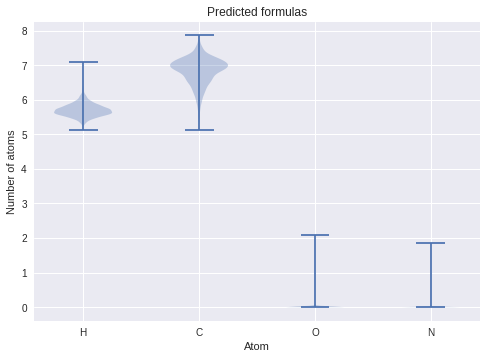

In [89]:
fig, ax = plt.subplots()

ax.violinplot(results.formulas.T)

ax.set(title="Predicted formulas", xticks=[1, 2, 3, 4,], xticklabels=["H", "C", "O", "N"], ylabel="Number of atoms", xlabel="Atom");